<a href="https://colab.research.google.com/github/pierrelouisbescond/medium_articles/blob/main/medium_employees_attrition_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
!pip install catboost

In [ ]:
import pandas as pd

from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from catboost import CatBoostClassifier

import shap

# The following lines should be used only on Google Colab
# to connectto Google Drive
from google.colab import drive
drive.mount('/content/drive')


## Data Exploration

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Medium/WA_Fn-UseC_-HR-Employee-Attrition.csv", index_col=9)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1470 entries, 1 to 2068
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   int64 
 14  JobRole                 

In [ ]:
# Detect columns with one unique value
print(df.columns[df.nunique() == 1])

df = df.drop(["EmployeeCount", "StandardHours", "Over18"], axis=1)


Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')


In [ ]:
# When relevant, convert categorical columns to numerical ones
yes_no_to_0_1_dict = {"Yes": 1, "No": 0}
business_travel_dict = {"Non-Travel": 0,
                        "Travel_Rarely": 1,
                        "Travel_Frequently": 2
                        }

df = df.replace({"Attrition": yes_no_to_0_1_dict})
df = df.replace({"OverTime": yes_no_to_0_1_dict})
df = df.replace({"BusinessTravel": business_travel_dict})

df.sample(10)


Age  Attrition  ...  YearsSinceLastPromotion  YearsWithCurrManager
EmployeeNumber                  ...                                               
1473             49          0  ...                        1                     2
686              26          0  ...                        0                     2
160              33          0  ...                        0                     7
1653             25          0  ...                        0                     7
396              49          0  ...                        1                     2
1588             39          0  ...                        7                     6
1419             29          0  ...                        0                     9
865              32          0  ...                        1                     3
2038             32          0  ...                        1                     2
857              36          0  ...                        4                    11

[10 rows x 31 columns]

In [ ]:
# Display original MaritalStatus column
df.filter(like="Marital").sample(10, random_state=22)


MaritalStatus
EmployeeNumber              
862                  Married
1464                 Married
349                 Divorced
1293                  Single
55                    Single
208                  Married
1792                Divorced
2040                  Single
1858                Divorced
2053                 Married

In [ ]:
# Convert categorical columns to numerical vectors
df = pd.get_dummies(df)


In [ ]:
# Display final MaritalStatus columns
df.filter(like="Marital").sample(10, random_state=22)


MaritalStatus_Divorced  ...  MaritalStatus_Single
EmployeeNumber                          ...                      
862                                  0  ...                     0
1464                                 0  ...                     0
349                                  1  ...                     0
1293                                 0  ...                     1
55                                   0  ...                     1
208                                  0  ...                     0
1792                                 1  ...                     0
2040                                 0  ...                     1
1858                                 1  ...                     0
2053                                 0  ...                     0

[10 rows x 3 columns]

In [ ]:
# Assess target imbalance
df.groupby("Attrition")["Attrition"].count()


Attrition
0    1233
1     237
Name: Attrition, dtype: int64

In [ ]:
# Prepare train and test dataset
X = df.drop("Attrition", axis=1)
y = df["Attrition"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)


## Models training

### Model Training - Round 1

In [ ]:
model = CatBoostClassifier(iterations=500, verbose=100, eval_metric="Recall")
model.fit(X_train, y_train);


Learning rate set to 0.020276
0:	learn: 0.2701149	total: 51.7ms	remaining: 25.8s
100:	learn: 0.2816092	total: 333ms	remaining: 1.32s
200:	learn: 0.5287356	total: 621ms	remaining: 923ms
300:	learn: 0.7011494	total: 904ms	remaining: 598ms
400:	learn: 0.8275862	total: 1.18s	remaining: 292ms
499:	learn: 0.9022989	total: 1.46s	remaining: 0us


In [ ]:
print("TRAIN PERFORMANCE:\n")
confusion_matrix_train = confusion_matrix(y_train, model.predict(X_train))
confusion_matrix_train = pd.DataFrame(confusion_matrix_train,
                                      index=["Actual_No", "Actual_Yes"],
                                      columns=["Predicted_No", "Predicted_Yes"])

display(confusion_matrix_train)

recall_resignation_train = confusion_matrix_train.iloc[1, 1] / confusion_matrix_train.iloc[1, :].sum()
print("Train Score: {}".format(round(model.score(X_train, y_train), 3)))
print("Train Recall: {}".format(round(recall_resignation_train, 3)))
print("\n* * * * * * * * * * * * * * * * * * *\n")
print("TEST PERFORMANCE:\n")
confusion_matrix_test = confusion_matrix(y_test, model.predict(X_test))
confusion_matrix_test = pd.DataFrame(confusion_matrix_test,
                                     index=["Actual_No", "Actual_Yes"],
                                     columns=["Predicted_No", "Predicted_Yes"])

display(confusion_matrix_test)

recall_resignation_test = confusion_matrix_test.iloc[1, 1] / confusion_matrix_test.iloc[1, :].sum()
print("Test Score: {}".format(round(model.score(X_test, y_test), 3)))
print("Test Recall: {}".format(round(recall_resignation_test, 3)))


TRAIN PERFORMANCE:



Predicted_No  Predicted_Yes
Actual_No            928              0
Actual_Yes            17            157

Train Score: 0.985
Train Recall: 0.902

* * * * * * * * * * * * * * * * * * *

TEST PERFORMANCE:



Predicted_No  Predicted_Yes
Actual_No            302              3
Actual_Yes            51             12

Test Score: 0.853
Test Recall: 0.19


### Model Training - Round 2 (using class weights)

In [ ]:
class_weights = dict({0:1, 1:5})

model = CatBoostClassifier(iterations=500,
                           verbose=100,
                           eval_metric="Recall",
                           class_weights=class_weights)

model.fit(X_train, y_train);


Learning rate set to 0.020276
0:	learn: 0.6666667	total: 3.11ms	remaining: 1.55s
100:	learn: 0.8793103	total: 301ms	remaining: 1.19s
200:	learn: 0.9425287	total: 590ms	remaining: 878ms
300:	learn: 0.9712644	total: 884ms	remaining: 585ms
400:	learn: 0.9942529	total: 1.17s	remaining: 289ms
499:	learn: 1.0000000	total: 1.46s	remaining: 0us


In [ ]:
print("TRAIN PERFORMANCE:\n")
confusion_matrix_train = confusion_matrix(y_train, model.predict(X_train))
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, index=["Actual_No", "Actual_Yes"], columns=["Predicted_No", "Predicted_Yes"])

display(confusion_matrix_train)

recall_resignation_train = confusion_matrix_train.iloc[1, 1] / confusion_matrix_train.iloc[1, :].sum()
print("Train Score: {}".format(round(model.score(X_train, y_train), 3)))
print("Train Recall: {}".format(round(recall_resignation_train, 3)))
print("\n* * * * * * * * * * * * * * * * * * *\n")
print("TEST PERFORMANCE:\n")
confusion_matrix_test = confusion_matrix(y_test, model.predict(X_test))
confusion_matrix_test = pd.DataFrame(confusion_matrix_test, index=["Actual_No", "Actual_Yes"], columns=["Predicted_No", "Predicted_Yes"])

display(confusion_matrix_test)

recall_resignation_test = confusion_matrix_test.iloc[1, 1] / confusion_matrix_test.iloc[1, :].sum()
print("Test Score: {}".format(round(model.score(X_test, y_test), 3)))
print("Test Recall: {}".format(round(recall_resignation_test, 3)))in)

recall_resignation_train = confusion_matrix_train.iloc[1, 1] / confusion_matrix_train.iloc[1, :].sum()
print("Train Score: {}".format(round(model.score(X_train, y_train), 3)))
print("Train Recall: {}".format(round(recall_resignation_train, 3)))
print("\n* * * * * * * * * * * * * * * * * * *\n")
print("TEST PERFORMANCE:\n")
confusion_matrix_test = confusion_matrix(y_test, model.predict(X_test))
confusion_matrix_test = pd.DataFrame(confusion_matrix_test,
                                     index=["Actual_No", "Actual_Yes"],
                                     columns=["Predicted_No", "Predicted_Yes"])

display(confusion_matrix_test)

recall_resignation_test = confusion_matrix_test.iloc[1, 1] / confusion_matrix_test.iloc[1, :].sum()
print("Test Score: {}".format(round(model.score(X_test, y_test), 3)))
print("Test Recall: {}".format(round(recall_resignation_test, 3)))


TRAIN PERFORMANCE:



Predicted_No  Predicted_Yes
Actual_No            923              5
Actual_Yes             0            174

Train Score: 0.995
Train Recall: 1.0

* * * * * * * * * * * * * * * * * * *

TEST PERFORMANCE:



Predicted_No  Predicted_Yes
Actual_No            288             17
Actual_Yes            38             25

Test Score: 0.851
Test Recall: 0.397


### Model Training - Round 3 (using under-sampling)

In [ ]:
cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_cc, y_cc)

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.


In [ ]:
class_weights = dict({0: 1, 1: 5})

model = CatBoostClassifier(iterations=500,
                           verbose=100,
                           eval_metric="Recall",
                           class_weights=class_weights)

model.fit(X_train, y_train);


Learning rate set to 0.0125
0:	learn: 0.9774011	total: 7.89ms	remaining: 3.94s
100:	learn: 1.0000000	total: 398ms	remaining: 1.57s
200:	learn: 1.0000000	total: 783ms	remaining: 1.16s
300:	learn: 1.0000000	total: 1.19s	remaining: 785ms
400:	learn: 1.0000000	total: 1.55s	remaining: 384ms
499:	learn: 1.0000000	total: 1.93s	remaining: 0us


In [ ]:
print("TRAIN PERFORMANCE:\n")
confusion_matrix_train = confusion_matrix(y_train, model.predict(X_train))
confusion_matrix_train = pd.DataFrame(confusion_matrix_train, index=["Actual_No", "Actual_Yes"], columns=["Predicted_No", "Predicted_Yes"])

display(confusion_matrix_train)

recall_resignation_train = confusion_matrix_train.iloc[1, 1] / confusion_matrix_train.iloc[1, :].sum()
print("Train Score: {}".format(round(model.score(X_train, y_train), 3)))
print("Train Recall: {}".format(round(recall_resignation_train, 3)))
print("\n* * * * * * * * * * * * * * * * * * *\n")
print("TEST PERFORMANCE:\n")
confusion_matrix_test = confusion_matrix(y_test, model.predict(X_test))
confusion_matrix_test = pd.DataFrame(confusion_matrix_test, index=["Actual_No", "Actual_Yes"], columns=["Predicted_No", "Predicted_Yes"])

display(confusion_matrix_test)

recall_resignation_test = confusion_matrix_test.iloc[1, 1] / confusion_matrix_test.iloc[1, :].sum()
print("Test Score: {}".format(round(model.score(X_test, y_test), 3)))
print("Test Recall: {}".format(round(recall_resignation_test, 3)))


TRAIN PERFORMANCE:



Predicted_No  Predicted_Yes
Actual_No            177              1
Actual_Yes             0            177

Train Score: 0.997
Train Recall: 1.0

* * * * * * * * * * * * * * * * * * *

TEST PERFORMANCE:



Predicted_No  Predicted_Yes
Actual_No             56              3
Actual_Yes             0             60

Test Score: 0.975
Test Recall: 1.0


## Explaining predictions with SHAP

### Original Features Importance with SciKit-Learn

In [ ]:
feat_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["Importance"])
feat_imp.sort_values(by="Importance", ascending=False).head(15)


Importance
StockOptionLevel                     8.041895
EducationField_Medical               7.476060
MaritalStatus_Married                6.608112
EducationField_Life Sciences         6.548846
MaritalStatus_Single                 6.473452
Gender_Female                        6.112067
Gender_Male                          5.548398
OverTime                             5.511141
MaritalStatus_Divorced               4.366390
Department_Research & Development    3.357589
JobRole_Research Director            2.784558
JobRole_Manufacturing Director       2.555876
YearsWithCurrManager                 2.395391
MonthlyIncome                        2.390963
RelationshipSatisfaction             2.262467

### SHAP Explanations

In [ ]:
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X)


In [ ]:
Employee_ID = 1
employees_profile = df[df.index == Employee_ID]
employees_profile = employees_profile.loc[:, (employees_profile != 0).any(axis=0)]
employees_profile.T


EmployeeNumber                    1
Age                              41
Attrition                         1
BusinessTravel                    1
DailyRate                      1102
DistanceFromHome                  1
Education                         2
EnvironmentSatisfaction           2
HourlyRate                       94
JobInvolvement                    3
JobLevel                          2
JobSatisfaction                   4
MonthlyIncome                  5993
MonthlyRate                   19479
NumCompaniesWorked                8
OverTime                          1
PercentSalaryHike                11
PerformanceRating                 3
RelationshipSatisfaction          1
TotalWorkingYears                 8
WorkLifeBalance                   1
YearsAtCompany                    6
YearsInCurrentRole                4
YearsWithCurrManager              5
Department_Sales                  1
EducationField_Life Sciences      1
Gender_Female                     1
JobRole_Sales Executive           1
MaritalStatus_Single              1

In [ ]:
shap.initjs()
index_choice = df.index.get_loc(Employee_ID)
shap.force_plot(shap_explainer.expected_value, shap_values[index_choice], X.iloc[index_choice])


In [ ]:
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_values, X)


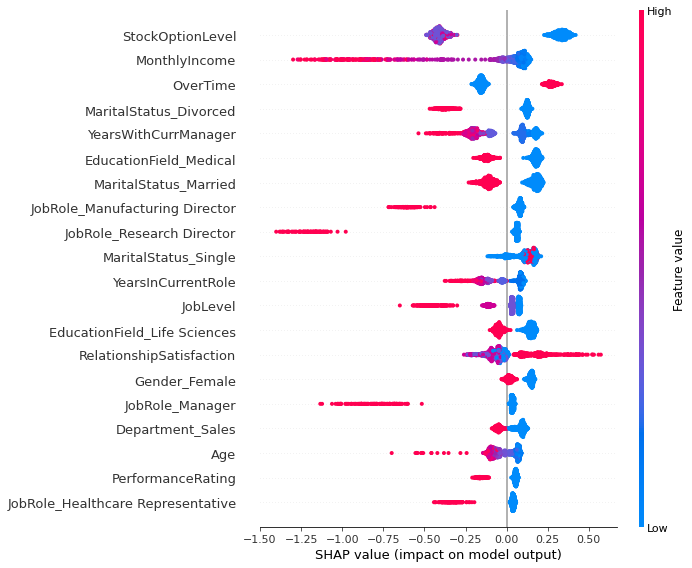

In [ ]:
shap.summary_plot(shap_values, X, X.columns)
